# Libraries

In [ ]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import warnings
import AppKit


#Pre Processing
import string
import shutil
import seaborn as sns
import matplotlib.pylab as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from dmba import classificationSummary, regressionSummary
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from dmba import plotDecisionTree, gainsChart, liftChart, classificationSummary, regressionSummary, adjusted_r2_score, AIC_score, BIC_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import recall_score
from sklearn import svm, metrics

In [ ]:
AppKit.NSBeep()

In [ ]:
#os.chdir('C:\\Users\\halle.davis\\Downloads\\') ## Halle's work folder path
#os.chdir('/Users/halledavis/Downloads/') ## Halle's personal folder path
#os.chdir('/users/clairephibbs/Desktop/Capstone') ## Claire's folder path
os.chdir('/Users/summerpurschke/Desktop/Capstone') ## Summer's folder path

In [ ]:
# accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
# violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')

# # inspections = pd.read_csv('Inspections.txt', sep= '|', encoding = 'latin-1')
# # mines = pd.read_csv('Mines.txt', sep= '|', encoding = 'latin-1')

# Pre-Processing

## Assessing Duplicates

In [ ]:
violations.duplicated().sum()

In [ ]:
accidents.duplicated().sum()

INSIGHT: No duplicate values in the violations and accidents dataframes.

## Assessing Nulls

### Violation Data

In [ ]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = violations.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

In [ ]:
# Fill in missing values
violations  = violations.replace('?', np.nan)

### Accident Data

In [ ]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = accidents.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

In [ ]:
# Fill in missing values
accidents  = accidents.replace('?', np.nan)

### INSPECTION_END_DT Missing Values: Remove INSPECTION_START_DT with year 2023

In [ ]:
# Visualizing the missing INSPECTION_END_DT's by year to test theory that majority of missings
# are coming from 2023 because inspection is still ongoing
missing_end_dt = violations[violations['INSPECTION_END_DT'].isnull()]

missing_end_dt['INSPECTION_BEGIN_DT'] = pd.to_datetime(missing_end_dt['INSPECTION_BEGIN_DT'])
missing_end_dt['Year'] = missing_end_dt['INSPECTION_BEGIN_DT'].dt.year
counts_by_year = missing_end_dt['Year'].value_counts().sort_index()

plt.bar(counts_by_year.index, counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Years of Start Dates with Missing End Dates')
plt.show()

print(counts_by_year)

INSIGHT: We can see that majority of the inspections with missing end dates are inspections that started in 2023, which makes sense, given that those inspections are likely still ongoing. Would make sense to remove year 2023 of INSPECTION_BEGIN_DT from dataframe. We can also see in counts_by_year that there are some missing end dates for some pretty early years (i.e., 2013, 2014, 2015). Inspection may have been terminated or for some other reason the inspection was never completed, so would make sense to remove these as well.

In [ ]:
# Copying dataframe for cleaned data
violations_cleaned = violations.copy()

# Converting 'INSPECTION_BEGIN_DT' to a datetime column 
violations_cleaned['INSPECTION_BEGIN_DT'] = pd.to_datetime(violations_cleaned['INSPECTION_BEGIN_DT'])

# Removing year 2023 from 'INSPECTION_LENGTH_DAYS' in violations df
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_BEGIN_DT'].dt.year != 2023]

In [ ]:
# confirming removal of 2023 from 'INSPECTION_BEGIN_DT' column
violations_cleaned['Year'] = violations_cleaned['INSPECTION_BEGIN_DT'].dt.year
violations_cleaned['Year'].value_counts().sort_index()

In [ ]:
# Dropping created year column 
violations_cleaned.drop(columns='Year', inplace=True)

# Removing 'INSPECTION_BEGIN_DT' from 2013-2022 with missing values 
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_END_DT'].notna()]
display(violations_cleaned.head())
display(violations_cleaned.shape)

NOTE: Dataset decreased from 2,812,757 rows to 2,771,401 rows after removing INSPECTION_BEGIN_DT 2023 and missing values in other years from 2013-2022. 

### MINE_TYPE: Filling in Missing Values 

In [ ]:
# Viewing the rows with missing value for 'MINE_TYPE', to best see how to address the nulls
missing_mine_type = violations_cleaned[violations_cleaned['MINE_TYPE'].isnull()]
missing_mine_type

INSIGHT: There are two mines with missing values for 'MINE_TYPE', 'MINE_ID' 3304704 and 3402225. Upon research and the data itself, the first Mine 3304704 is a metal producing mine. From the EDA, we know that a large majority of metal producing mines are surface mines, so, to impute the missing values for Mine 3304704, we could fill it in with 'surface'. For the other missing value for 'MINE_TYPE', it is a coal producing mine. Again, from the EDA we know that a large majority of coal producing mines are underground, so we could impute the missing value for mine 3402225 with 'underground'. They could also just be removed given that only 14 MINE_TYPE's are missing values.

Source: https://minesdatabase.com/mines/view/3304704

In [ ]:
# Filling in missing values for MINE_TYPE

# MINE_ID 3304704 as MINE_TYPE Surface
violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3304704, 'MINE_TYPE'] = violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3304704, 'MINE_TYPE'].fillna("Surface")

# MINE_ID 3402225 as MINE_TYPE Underground
violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3402225, 'MINE_TYPE'] = violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3402225, 'MINE_TYPE'].fillna("Underground")

### Removing Columns and Rows with High Proportion of Missings

In [ ]:
# Removing columns with 24% or more missing values 
violations_cleaned = violations_cleaned.drop(columns=['CONTRACTOR_ID', 'SECTION_OF_ACT_2',
                                             'ORIG_TERM_DUE_DT', 'ORIG_TERM_DUE_TIME', 'VACATE_DT',
                                             'VACATE_TIME', 'INITIAL_VIOL_NO', 'REPLACED_BY_ORDER_NO',
                                             'WRITTEN_NOTICE', 'ENFORCEMENT_AREA', 'PRIMARY_OR_MILL',
                                             'RIGHT_TO_CONF_DT', 'DOCKET_NO', 'DOCKET_STATUS_CD', 'CONTESTED_DT'])

display(violations_cleaned.head())
display(violations_cleaned.shape)


In [ ]:
# Removing rows with more than 5 missing values since there isn't
# a great way to impute our data
violations_cleaned = violations_cleaned.dropna(thresh=violations_cleaned.shape[1] - 5)
display(violations_cleaned.head())
display(violations_cleaned.shape)

NOTE: Dataset size decreased from 2,771,401 to 2,720,784.

In [ ]:
violations_cleaned.shape
violations_cleaned.dropna(subset=['NO_AFFECTED', 'NEGLIGENCE', 'LIKELIHOOD', 'MINE_TYPE',
       'COAL_METAL_IND', 'CIT_ORD_SAFE', 'SPECIAL_ASSESS'])
violations_cleaned.shape

## Data Filtering

### VIOLATOR_TYPE_CD: Filter to only operator mines

In [ ]:
violations_cleaned = violations_cleaned.loc[violations_cleaned['VIOLATOR_TYPE_CD'] == 'Operator']
display(violations_cleaned.head())
display(violations_cleaned.shape)

In [ ]:
violations_cleaned.columns

NOTE: Dataset decreased from 2,720,784 to 2,537,146 after removing 'VIOLATOR_TYPE_CD' == 'Contractor'.

### Unnecessary Feature Removal (CONTROLLER_ID, CONTROLLER_NAME, ASMT_GENERATED_IND, LATEST_TERM_DUE_DT, LATEST_TERM_DUE_TIME, TERMINATION_DT, TERMINATION_TIME)

In [ ]:
violations_cleaned = violations_cleaned.drop(columns=['CONTROLLER_ID', 'CONTROLLER_NAME', 'ASMT_GENERATED_IND', 'LATEST_TERM_DUE_DT',
                                                      'LATEST_TERM_DUE_TIME', 'TERMINATION_DT', 'TERMINATION_TIME'])
display(violations_cleaned.head())
display(violations_cleaned.shape)

In [ ]:
# Viewing sum of missing values
violations_cleaned.isna().sum()

In [ ]:
# Converts dataframe to a csv 
# violations_cleaned.to_csv('violations_cleaned.csv', index=False)

## Feature Engineering

### Creating Column: 'INSPECTION_LENGTH_DAYS' from 'INSPECTION_BEGIN_DT' and 'INSPECTION_END_DT'

In [ ]:
# Creating new column 'INSPECTION_LENGTH_DAYS' from 'INSPECTION_BEGIN_DT' and 'INSPECTION_END_DT'
violations_cleaned['INSPECTION_LENGTH_DAYS'] = pd.to_datetime(violations_cleaned['INSPECTION_END_DT']) - pd.to_datetime(violations_cleaned['INSPECTION_BEGIN_DT'])

violations_cleaned['INSPECTION_LENGTH_DAYS']

In [ ]:
# Descriptive statistics of 'INSPECTION_LENGTH_DAYS'
violations_cleaned.INSPECTION_LENGTH_DAYS.describe()

INSIGHT: A new column has been created called 'INSPECTION_LENGTH_DAYS' which represents the number of days between an inspection end date and inspection begin date. The average inspection length is 37 days with a standard deviation of 42 days. After creating the new column, outliers are removed based on standard deviation/z-scores, same method used above to remove outliers. After removing outliers from the INSPECTION_LENGTH_DAYS column, the dataframe decreases from 2,406,620 to 2,391,418.

### Creating Column: 'VIOLATION_SEVERITY' from 'INJ_ILLNESS'

The original variable 'INJ_ILLNESS' is a categorical value assigned to a violation for the gravity of injury. There are 4 possible categories: Fatal, LostDays, NoLostDays, or Permanent. A new column will be created called 'VIOLATION_SEVERITY' that is a numerical representation of the 'INJ_ILLNESS' categories. 0 will be used to denote NoLostDays, 1 for LostDays, 2 for Permanent, and 3 for Fatal.

In [ ]:
# Define the mapping dictionary for hierarchical representation
severity_mapping = {
    'Fatal': 3,
    'Permanent': 2,
    'LostDays': 1,
    'NoLostDays': 0
}

# Create the new column 'VIOLATION_SEVERITY' based on the mapping
violations_cleaned['VIOLATION_SEVERITY'] = violations_cleaned['INJ_ILLNESS'].map(severity_mapping)
violations_cleaned['VIOLATION_SEVERITY']

### Creating Column: 'SIG_SUB_BINARY' from 'SIG_SUB'

The original variable 'SIG_SUB' has a value of either yes/no. A new column will be created called 'SIG_SUB_BINARY' that is a numerical representation of the 'SIG_SUB' categories. 0 will be used to denote No, and 1 for Yes.

In [ ]:
# Change to binary yes or no 
violations_cleaned['SIG_SUB_BINARY'] = violations_cleaned['SIG_SUB'].replace({'N': 0, 'Y': 1})
violations_cleaned['SIG_SUB_BINARY']

### Creating Column: 'NEGLIGENCE_SCORES' from 'NEGLIGENCE'

In [ ]:
# NEGLIGENCE
# Change to Ordinal values
negligence_mapping = {
    'LowNegligence': 1,
    'ModNegligence': 2,
    'HighNegligence': 3,
    'NoNegligence': 0,
    'Reckless': 4
}

violations_cleaned['NEGLIGENCE_SCORE'] = violations_cleaned['NEGLIGENCE'].replace(negligence_mapping)
violations_cleaned['NEGLIGENCE_SCORE']

### Creating Column: 'LIKELIHOOD_SCORE' from 'LIKELIHOOD'

In [ ]:
# LIKELIHOOD
# Change to Ordinal values
likelihood_mapping = {
    'Unlikely': 1,
    'Reasonably': 2,
    'NoLikelihood': 0,
    'Highly': 3,
    'Occurred': 4
}

violations_cleaned['LIKELIHOOD_SCORE'] = violations_cleaned['LIKELIHOOD'].map(likelihood_mapping)
violations_cleaned['LIKELIHOOD_SCORE']

### Creating Column: One Hot Encoding

In [ ]:
violations_cleaned.SECTION_OF_ACT.value_counts(normalize = True)

In [ ]:
len(pd.unique(violations['SECTION_OF_ACT']))

In [ ]:
top10sectionsviolated = ['316(b)', '103(h)', '316(b)(2)(A)', '103(d)', '109(a)', '316(b)(2)(F)(ii)', '103(a)', '104(b)', '104(a)', '104(g)(1)']

#violations_cleaned.loc[~violations_cleaned['SECTION_OF_ACT'].isin(top10sectionsviolated), 'SECTION_OF_ACT_FILTERED'] = violations_cleaned['SECTION_OF_ACT']
violations_cleaned['SECTION_OF_ACT_FILTERED'] = np.where(violations_cleaned['SECTION_OF_ACT'].isin(top10sectionsviolated), violations_cleaned['SECTION_OF_ACT'], '0')

violations_cleaned['SECTION_OF_ACT_FILTERED']

In [ ]:
violations_cleaned.SECTION_OF_ACT_FILTERED.value_counts(normalize = True)

In [ ]:
violations_cleaned = pd.get_dummies(violations_cleaned, columns=['SECTION_OF_ACT_FILTERED', 'MINE_TYPE', 'COAL_METAL_IND', 'CIT_ORD_SAFE', 'SPECIAL_ASSESS'])
violations_cleaned.head()

## Merge Violations and Accidents

For each row in violations, add columns ['Accident_30','Accident_60', 'Accident_90'] as binary columns that show if an accident (or multiple accidents) occurred 30/60/90 days after the violation_data['VIOLATION_OCCUR_DT']. You can find out whether an accident happened in the time following a violation at a specific mine by looking at the accidents dataset, in the row that has the same ['MINE_ID'] value as the violations row that we're looking at. If any accident column (ACCIDENT_1	ACCIDENT_2	ACCIDENT_3....) has a date within 30 days, ['Accident_30'] should be 1. Same logic for 60 and 90 days. This dataset is very large so I rather not iterate through rows if possible

In [ ]:
sample_size = 100000

In [ ]:
violations_data = violations_cleaned.copy()

In [ ]:
# Violation Occur Date is not always the same as Violation Issue Date - 
# Have to decide which one to use 
violations_data[violations_data['VIOLATION_ISSUE_DT'] != violations_data['VIOLATION_OCCUR_DT']][['VIOLATION_ISSUE_DT', 'VIOLATION_OCCUR_DT']]

In [ ]:
### Create a new df with the dates of accidents at each mine

# Grab just the accident dates and the Mine ID columns from accidents data
accident_dates = accidents[['MINE_ID', 'ACCIDENT_DT']].copy()

# Convert the 'ACCIDENT_DT' column to datetime format using .loc
accident_dates.loc[:, 'ACCIDENT_DT'] = pd.to_datetime(accident_dates['ACCIDENT_DT'], format='%m/%d/%Y')

# Create a new column to count occurrences of accidents for each MINE_ID using .loc
accident_dates.loc[:, 'ACCIDENT_NUMBER'] = accident_dates.groupby('MINE_ID').cumcount() + 1

# Pivot the DataFrame
accident_dates = accident_dates.pivot(index='MINE_ID', columns='ACCIDENT_NUMBER', values='ACCIDENT_DT')

# Rename the columns to have meaningful names
accident_dates.columns = ['ACCIDENT_' + str(i) for i in accident_dates.columns]

# Reset the index if needed
accident_dates = accident_dates.reset_index()

Insight: There are duplicated VIOLATION_NO values

In [ ]:
violations_data['VIOLATION_NO'].nunique() == violations_data.shape[0]

In [ ]:
# Check for duplicate 'VIOLATION_NO' values
duplicates_mask = violations_data.duplicated(subset='VIOLATION_NO', keep=False)

# Select rows with duplicated 'VIOLATION_NO' values
violations_data[duplicates_mask]

In [ ]:
# accidents_violations_merged = violations_data[['VIOLATION_OCCUR_DT', 'MINE_ID', 'VIOLATION_NO']].head(1000).merge(accident_dates.head(1000), on = 'MINE_ID', how = 'left')

In [ ]:
accidents_violations_merged = violations_data.head(sample_size).merge(accident_dates.head(sample_size), on = 'MINE_ID', how = 'left')

In [ ]:
### Method 2 with all other info

# accidents_violations_merged = violations_data.head(1000000).merge(accident_dates.head(1000000), on = 'MINE_ID', how = 'outer')

#Reorder the columns to move 'VIOLATION_NO' and 'MINE_ID' to the first two columns
new_order = ['VIOLATION_OCCUR_DT', 'MINE_ID', 'VIOLATION_NO'] + [col for col in accidents_violations_merged.columns if col not in ['VIOLATION_NO', 'MINE_ID']]

# Reassign the DataFrame with the new column order
accidents_violations_merged = accidents_violations_merged[new_order]

In [ ]:
### Find the index where the accident date columns start 

# Find the index where the 'ACCIDENT_i' columns start
accident_columns_start_index = accidents_violations_merged.columns.get_loc('ACCIDENT_1')

# Display the index where the 'ACCIDENT_i' columns start
print("The 'ACCIDENT_i' columns start at index:", accident_columns_start_index)

In [ ]:
# There are duplicated columns after the merge - drop them so that the 30/60/90 works
accidents_violations_merged = accidents_violations_merged.iloc[:, ~accidents_violations_merged.columns.duplicated()]

In [ ]:
# Check that duplicates were dropped - this was a duplicate
accidents_violations_merged['VIOLATION_OCCUR_DT']

In [ ]:
### Columns for if an accident occured at that mine 30/60/90 days after the violation occured

# Convert the 'ACCIDENT_1', 'ACCIDENT_2', etc., columns to datetime format - all columns except the first two
for col in accidents_violations_merged.columns[accident_columns_start_index:]:
    accidents_violations_merged[col] = pd.to_datetime(accidents_violations_merged[col], format='%Y-%m-%d')

# Convert the 'VIOLATION_OCCUR_DT' column to datetime format
accidents_violations_merged['VIOLATION_OCCUR_DT'] = pd.to_datetime(accidents_violations_merged['VIOLATION_OCCUR_DT'], format='%m/%d/%Y')

# Check if any accident date is within 30 days of the violation occurrence date
accident_columns = [col for col in accidents_violations_merged.columns[2:] if 'ACCIDENT' in col]

# Group by 'MINE_ID' and create a list of unique dates for each group
accidents_violations_merged['ACCIDENT_DATES'] = accidents_violations_merged[accident_columns].apply(lambda x: x.dropna().unique(), axis=1)

# Function to check if any date is within 30 days of the violation occurrence date
def check_within_30_days(accident_dates, violation_date):
    if pd.isnull(accident_dates).any():
        return pd.NA
    return any((violation_date <= date <= violation_date + pd.Timedelta(days=30)) for date in accident_dates)

# Function to check if any date is within 60 days of the violation occurrence date
def check_within_60_days(accident_dates, violation_date):
    if pd.isnull(accident_dates).any():
        return pd.NA
    return any((violation_date <= date <= violation_date + pd.Timedelta(days=60)) for date in accident_dates)

# Function to check if any date is within 90 days of the violation occurrence date
def check_within_90_days(accident_dates, violation_date):
    if pd.isnull(accident_dates).any():
        return pd.NA
    return any((violation_date <= date <= violation_date + pd.Timedelta(days=90)) for date in accident_dates)

# Apply the function to create the 'ACCIDENT_30' column
accidents_violations_merged['ACCIDENT_in_30'] = accidents_violations_merged.apply(lambda row: check_within_30_days(row['ACCIDENT_DATES'], row['VIOLATION_OCCUR_DT']), axis=1)

# Apply the function to create the 'ACCIDENT_60' column
accidents_violations_merged['ACCIDENT_in_60'] = accidents_violations_merged.apply(lambda row: check_within_60_days(row['ACCIDENT_DATES'], row['VIOLATION_OCCUR_DT']), axis=1)

# Apply the function to create the 'ACCIDENT_90' column
accidents_violations_merged['ACCIDENT_in_90'] = accidents_violations_merged.apply(lambda row: check_within_90_days(row['ACCIDENT_DATES'], row['VIOLATION_OCCUR_DT']), axis=1)

# Convert the boolean values in 'ACCIDENT_30', 'ACCIDENT_60', and 'ACCIDENT_90' to 1 or 0
accidents_violations_merged['ACCIDENT_in_30'] = accidents_violations_merged['ACCIDENT_in_30'].astype(int)
accidents_violations_merged['ACCIDENT_in_60'] = accidents_violations_merged['ACCIDENT_in_60'].astype(int)
accidents_violations_merged['ACCIDENT_in_90'] = accidents_violations_merged['ACCIDENT_in_90'].astype(int)

# Drop the temporary 'ACCIDENT_DATES' column
accidents_violations_merged = accidents_violations_merged.drop(columns='ACCIDENT_DATES')

In [ ]:
# accidents_violations_merged[(accidents_violations_merged['ACCIDENT_in_60']== 1) &(accidents_violations_merged['ACCIDENT_in_90']== 1)][['MINE_ID', 'VIOLATION_OCCUR_DT', 'ACCIDENT_in_30',  'ACCIDENT_in_60',  'ACCIDENT_in_90']]

In [ ]:
### Drop all of the Accident Columns 

#List all columns that start with 'ACCIDENT_'
accident_columns_to_drop = [col for col in accidents_violations_merged.columns if col.startswith('ACCIDENT_')]

# Keep only the desired columns: 'ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90'
columns_to_keep = ['ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90']

# Combine the columns to drop and the columns to keep
columns_to_drop = [col for col in accident_columns_to_drop if col not in columns_to_keep]

# Drop the columns from the DataFrame
accidents_violations_merged = accidents_violations_merged.drop(columns=columns_to_drop)

In [ ]:
### EDA for Merged

# Count the number of accidents for each mine
accident_counts = accident_dates.iloc[:, 1:].count(axis=1)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(accident_counts, bins=10)  # Adjust the number of bins as needed

# Set labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.title('Accidents per Mine Frequency Distribution')

# Show the plot
plt.show()

In [ ]:
# Count the number of '1's in each column
accident_30_count = accidents_violations_merged['ACCIDENT_in_30'].value_counts()[1]
accident_60_count = accidents_violations_merged['ACCIDENT_in_60'].value_counts()[1]
accident_90_count = accidents_violations_merged['ACCIDENT_in_90'].value_counts()[1]

# Create a list of counts and labels
counts = [accident_30_count, accident_60_count, accident_90_count]
labels = ['ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the bar chart
ax.bar(labels, counts)

# Set labels and title
ax.set_xlabel("Time Frame after Violation")
ax.set_ylabel("Count of Accidents")
ax.set_title("Count of Accidents in 30, 60, and 90 Days after Violations")

# Show the plot
plt.show()

In [ ]:
### Correlation between accidents occuring and each of the columns 

# Select the columns for the heatmap
#heatmap_columns = ['ACCIDENT_in_30_TEST', 'ACCIDENT_in_60_TEST', 'ACCIDENT_in_90_TEST', 'SIG_SUB', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'NEGLIGENCE', 'NO_AFFECTED', 'LIKELIHOOD']
heatmap_columns = ['ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90', 'SIG_SUB_BINARY', 'NEGLIGENCE_SCORE', 'NO_AFFECTED', 'LIKELIHOOD_SCORE', 'VIOLATION_SEVERITY', 'INSPECTION_LENGTH_DAYS']

# Calculate the correlation matrix
correlation_matrix = accidents_violations_merged[heatmap_columns].corr()

# Set seaborn context and font scale
sns.set(font_scale=1.2)
sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12})

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set title and display the plot
plt.title("Correlation Heatmap")
plt.show()

# Train Test Split

In [ ]:
data = accidents_violations_merged.dropna()

In [ ]:
accidents_violations_merged.columns

In [ ]:
data_X = data.drop(columns = ['VIOLATION_OCCUR_DT', 'MINE_ID', 'VIOLATION_NO',
                    'EVENT_NO', 'INSPECTION_BEGIN_DT', 'INSPECTION_END_DT', 'VIOLATOR_ID', 'PART_SECTION',
                    'VIOLATOR_NAME', 'VIOLATOR_TYPE_CD', 'MINE_NAME','VIOLATION_ISSUE_DT', 'SECTION_OF_ACT',
                    'SECTION_OF_ACT_1','CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR','VIOLATION_ISSUE_TIME', 'SIG_SUB',
                    'TERMINATION_TYPE','FINAL_ORDER_ISSUE_DT', 'PROPOSED_PENALTY','INJ_ILLNESS',
                    'AMOUNT_DUE', 'AMOUNT_PAID', 'BILL_PRINT_DT', 'LAST_ACTION_CD',
                    'LAST_ACTION_DT', 'CONTESTED_IND', 'VIOLATOR_INSPECTION_DAY_CNT', 'INSPECTION_LENGTH_DAYS',
                    'VIOLATION_SEVERITY', 'SIG_SUB_BINARY', 'NEGLIGENCE', 'LIKELIHOOD','VIOLATOR_VIOLATION_CNT',
                    'ACCIDENT_in_30', 'ACCIDENT_in_60','ACCIDENT_in_90',
                    'CIT_ORD_SAFE_Citation', 'CIT_ORD_SAFE_Notice', 'CIT_ORD_SAFE_Order', 'CIT_ORD_SAFE_Safeguard', 'SPECIAL_ASSESS_N', 'SPECIAL_ASSESS_Y' 
                    ]) #dropping all non predictor columns


In [ ]:
data_X.columns

In [ ]:
# Predict 30

X_30 = data_X.copy()
y_30 = data['ACCIDENT_in_30']

X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30,y_30, train_size=0.65, random_state = 42)

X_train_30, X_val_30, y_train_30, y_val_30 = train_test_split(X_train_30, y_train_30, test_size=0.25, random_state=1)

In [ ]:
# Predict 60

X_60 = data_X.copy()
y_60 = data['ACCIDENT_in_60']

X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(X_60,y_60, train_size=0.65, random_state = 42)

X_train_60, X_val_60, y_train_60, y_val_60 = train_test_split(X_train_60, y_train_60, test_size=0.25, random_state=1)

In [ ]:
# Predict 90

X_90 = data_X.copy()
y_90 = data['ACCIDENT_in_90']

X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90,y_90, train_size=0.65, random_state = 42)

X_train_90, X_val_90, y_train_90, y_val_90 = train_test_split(X_train_90, y_train_90, test_size=0.25, random_state=1)

In [ ]:
X_train_30.head()

## Removing Outliers from Training Sets

We waited to remove the outliers in 'NO_AFFECTED' until after partioning the dataset into training and testing sets, to ensure our test sets contain extreme values. This will ensure the quality of model performance on our test sets, since in real-life, there are likely to be outliers in the data that our model will need to deal with.

In [ ]:
# Removing outliers from X_train_30

numeric_vars = ['NO_AFFECTED']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed_30 = X_train_30.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((X_train_30[column_name] - X_train_30[column_name].mean()) / X_train_30[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    X_train_30 = outliers_removed_30[z_scores < z_score_threshold]

display(X_train_30.shape)

In [ ]:
# Removing outliers from X_train_60

numeric_vars = ['NO_AFFECTED']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed_60 = X_train_60.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((X_train_60[column_name] - X_train_60[column_name].mean()) / X_train_60[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    X_train_60 = outliers_removed_60[z_scores < z_score_threshold]

display(X_train_60.shape)

In [ ]:
# Removing outliers from X_train_90

numeric_vars = ['NO_AFFECTED']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed_90 = X_train_90.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((X_train_90[column_name] - X_train_90[column_name].mean()) / X_train_90[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    X_train_90 = outliers_removed_90[z_scores < z_score_threshold]

display(X_train_90.shape)

In [ ]:
AppKit.NSBeep()

NOTE: No outliers found in 'NO_AFFECTED'.

# Modeling

## Random Forest

In [160]:
# Base 30 
rf_30 = RandomForestClassifier()
rf_30.fit(X_train_30, y_train_30)

rf_pred_30 = rf_30.predict(X_test_30)

print("Random Forest \nBase 30 Model \n")
classificationSummary(y_test_30, rf_pred_30)
print(classification_report(y_test_30, rf_pred_30))

Random Forest 
Base 30 Model 

Confusion Matrix (Accuracy 0.8235)

       Prediction
Actual  0  1
     0 34  1
     1 11 22
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.96      0.67      0.79        33

    accuracy                           0.82        68
   macro avg       0.86      0.82      0.82        68
weighted avg       0.85      0.82      0.82        68



In [161]:
# Tuned 30
rfc=RandomForestClassifier(random_state=42)

In [162]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [163]:
rf_30_tune = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_30_tune.fit(X_val_30, y_val_30)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [164]:
rf_30_tune.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 200}

In [165]:
rf_30_tuned=RandomForestClassifier(random_state=42, n_estimators= 200, max_depth=4, criterion='gini')

In [166]:
rf_30_tuned.fit(X_train_30, y_train_30)

rf_30_tuned_pred = rf_30_tuned.predict(X_test_30)

print("Random Forest \nTuned 30 Model \n")
classificationSummary(y_test_30, rf_30_tuned_pred)
print(classification_report(y_test_30, rf_30_tuned_pred))

rf_classification_report_30 = classification_report(y_test_30, rf_30_tuned_pred, output_dict=True)

Random Forest 
Tuned 30 Model 

Confusion Matrix (Accuracy 0.8235)

       Prediction
Actual  0  1
     0 34  1
     1 11 22
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.96      0.67      0.79        33

    accuracy                           0.82        68
   macro avg       0.86      0.82      0.82        68
weighted avg       0.85      0.82      0.82        68



In [167]:
# Base 60
rf_60 = RandomForestClassifier()
rf_60.fit(X_train_60, y_train_60)

rf_pred_60 = rf_60.predict(X_test_60)

print("Random Forest \nBase 60 Model \n")
classificationSummary(y_test_60, rf_pred_60)
print(classification_report(y_test_60, rf_pred_60))

Random Forest 
Base 60 Model 

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



In [168]:
# Tuned 60
rf_60_tune = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_60_tune.fit(X_val_60, y_val_60)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [169]:
rf_60_tune.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 200}

In [170]:
rf_60_tuned=RandomForestClassifier(random_state=42, n_estimators= 200, max_depth=4, criterion='gini')

In [171]:
rf_60_tuned.fit(X_train_60, y_train_60)

rf_60_tuned_pred = rf_60_tuned.predict(X_test_60)

print("Random Forest \nTuned 60 Model \n")
classificationSummary(y_test_60, rf_60_tuned_pred)
print(classification_report(y_test_60, rf_60_tuned_pred))

rf_classification_report_60 = classification_report(y_test_60, rf_60_tuned_pred, output_dict=True)

Random Forest 
Tuned 60 Model 

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



In [172]:
# Base 90
rf_90 = RandomForestClassifier()
rf_90.fit(X_train_90, y_train_90)

rf_pred_90 = rf_90.predict(X_test_90)

print("Random Forest \nBase 90 Model \n")
classificationSummary(y_test_90, rf_pred_90)
print(classification_report(y_test_90, rf_pred_90))

Random Forest 
Base 90 Model 

Confusion Matrix (Accuracy 0.7353)

       Prediction
Actual  0  1
     0 17  4
     1 14 33
              precision    recall  f1-score   support

           0       0.55      0.81      0.65        21
           1       0.89      0.70      0.79        47

    accuracy                           0.74        68
   macro avg       0.72      0.76      0.72        68
weighted avg       0.79      0.74      0.74        68



In [173]:
# Tuned 90
rf_90_tune = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_90_tune.fit(X_val_90, y_val_90)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [174]:
rf_90_tune.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}

In [175]:
rf_90_tuned=RandomForestClassifier(random_state=42, n_estimators= 200, max_depth=4, criterion='gini')

In [176]:
rf_90_tuned.fit(X_train_90, y_train_90)

rf_90_tuned_pred = rf_90_tuned.predict(X_test_90)

print("Random Forest \nTuned 90 Model \n")
classificationSummary(y_test_90, rf_90_tuned_pred)
print(classification_report(y_test_90, rf_90_tuned_pred))

rf_classification_report_90 = classification_report(y_test_90, rf_90_tuned_pred, output_dict=True)

Random Forest 
Tuned 90 Model 

Confusion Matrix (Accuracy 0.6618)

       Prediction
Actual  0  1
     0 20  1
     1 22 25
              precision    recall  f1-score   support

           0       0.48      0.95      0.63        21
           1       0.96      0.53      0.68        47

    accuracy                           0.66        68
   macro avg       0.72      0.74      0.66        68
weighted avg       0.81      0.66      0.67        68



## Logistic Regression

In [177]:
# Tuned 30
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val_30, y_val_30)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best: 0.794444 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786111 (0.213745) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.713889 (0.182172) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.050000) wit

In [178]:
lr_30 = LogisticRegression (penalty="l2" , C=100, solver='newton-cg' )
lr_30.fit(X_train_30, y_train_30)

lr_pred_30 = lr_30.predict(X_test_30)

print("Logistic Regression \nTuned 30 Model \n")
classificationSummary(y_test_30, lr_pred_30)
print(classification_report(y_test_30, lr_pred_30))

lr_classification_report_30 = classification_report(y_test_30, lr_pred_30, output_dict=True)

Logistic Regression 
Tuned 30 Model 

Confusion Matrix (Accuracy 0.8382)

       Prediction
Actual  0  1
     0 35  0
     1 11 22
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        35
           1       1.00      0.67      0.80        33

    accuracy                           0.84        68
   macro avg       0.88      0.83      0.83        68
weighted avg       0.88      0.84      0.83        68



In [179]:
# Tuned 60
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val_60, y_val_60)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best: 0.794444 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786111 (0.213745) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.713889 (0.182172) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.050000) wit

In [180]:
lr_60 = LogisticRegression (penalty="l2" , C=100, solver='newton-cg' )
lr_60.fit(X_train_60, y_train_60)

lr_pred_60 = lr_60.predict(X_test_60)

print("Logistic Regression \nTuned 60 Model \n")
classificationSummary(y_test_60, lr_pred_60)
print(classification_report(y_test_60, lr_pred_60))

lr_classification_report_60 = classification_report(y_test_60, lr_pred_60, output_dict=True)


Logistic Regression 
Tuned 60 Model 

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



In [181]:
# Tuned 90
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val_90, y_val_90)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best: 0.780556 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.761111 (0.218087) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.761111 (0.218087) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761111 (0.218087) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.750000 (0.230740) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.750000 (0.230740) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761111 (0.218087) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.780556 (0.197769) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.780556 (0.197769) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.780556 (0.197769) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.741667 (0.131498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.741667 (0.131498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.741667 (0.131498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.741667 (0.131498) wit

In [182]:
lr_90 = LogisticRegression (penalty="l2" , C=10, solver='liblinear' )
lr_90.fit(X_train_90, y_train_90)

lr_pred_90 = lr_90.predict(X_test_90)
classificationSummary(y_test_90, lr_pred_90)
print(classification_report(y_test_90, lr_pred_90))

lr_classification_report_90 = classification_report(y_test_90, lr_pred_90, output_dict=True)

Confusion Matrix (Accuracy 0.6618)

       Prediction
Actual  0  1
     0 20  1
     1 22 25
              precision    recall  f1-score   support

           0       0.48      0.95      0.63        21
           1       0.96      0.53      0.68        47

    accuracy                           0.66        68
   macro avg       0.72      0.74      0.66        68
weighted avg       0.81      0.66      0.67        68



## Naive Bayes

In [183]:
# ACCIDENT_in_30 NB model tuning
nb_30 = BernoulliNB()

param_grid_30 = {'alpha': np.linspace(0.1, 1.0, 10)}

grid_search_30 = GridSearchCV(nb_30, param_grid_30, cv=5, scoring='accuracy')
grid_search_30.fit(X_train_30, y_train_30)

alpha_30 = grid_search_30.best_params_['alpha']
alpha_30

0.5

In [184]:
# ACCIDENT_in_30 NB model training
nb_30_model = BernoulliNB(alpha = alpha_30)
nb_30_model.fit(X_train_30, y_train_30)

# ACCIDENT_in_30 NB model testing
nb_pred_30 = nb_30_model.predict(X_test_30)

# ACCIDENT_in_30 NB model results
classificationSummary(y_test_30, nb_pred_30)
print(classification_report(y_test_30, nb_pred_30))

nb_classification_report_30 = classification_report(y_test_30, nb_pred_30, output_dict=True)

Confusion Matrix (Accuracy 0.8382)

       Prediction
Actual  0  1
     0 34  1
     1 10 23
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        35
           1       0.96      0.70      0.81        33

    accuracy                           0.84        68
   macro avg       0.87      0.83      0.83        68
weighted avg       0.86      0.84      0.83        68



In [185]:
# ACCIDENT_in_60 NB model tuning
nb_60 = BernoulliNB()

param_grid_60 = {'alpha': np.linspace(0.1, 1.0, 10)}

grid_search_60 = GridSearchCV(nb_60, param_grid_60, cv=5, scoring='accuracy')
grid_search_60.fit(X_train_60, y_train_60)

alpha_60 = grid_search_60.best_params_['alpha']
alpha_60

0.4

In [186]:
# ACCIDENT_in_60 NB model training
nb_60_model = BernoulliNB(alpha = alpha_60)
nb_60_model.fit(X_train_60, y_train_60)

# ACCIDENT_in_60 NB model testing
nb_pred_60 = nb_60_model.predict(X_test_60)

# ACCIDENT_in_60 NB model results
classificationSummary(y_test_60, nb_pred_60)
print(classification_report(y_test_60, nb_pred_60))

nb_classification_report_60 = classification_report(y_test_60, nb_pred_60, output_dict=True)

Confusion Matrix (Accuracy 0.7941)

       Prediction
Actual  0  1
     0 31  1
     1 13 23
              precision    recall  f1-score   support

           0       0.70      0.97      0.82        32
           1       0.96      0.64      0.77        36

    accuracy                           0.79        68
   macro avg       0.83      0.80      0.79        68
weighted avg       0.84      0.79      0.79        68



In [187]:
# ACCIDENT_in_90 NB model tuning
nb_90 = BernoulliNB()

param_grid_90 = {'alpha': np.linspace(0.1, 1.0, 10)}

grid_search_90 = GridSearchCV(nb_90, param_grid_90, cv=5, scoring='accuracy')
grid_search_90.fit(X_train_90, y_train_90)

alpha_90 = grid_search_90.best_params_['alpha']
alpha_90

0.1

In [188]:
# ACCIDENT_in_90 NB model training
nb_90_model = BernoulliNB(alpha = alpha_90)
nb_90_model.fit(X_train_90, y_train_90)

# ACCIDENT_in_90 NB model testing
nb_pred_90 = nb_90_model.predict(X_test_90)

# ACCIDENT_in_90 NB model results
classificationSummary(y_test_90, nb_pred_90)
print(classification_report(y_test_90, nb_pred_90))

nb_classification_report_90 = classification_report(y_test_90, nb_pred_90, output_dict=True)

Confusion Matrix (Accuracy 0.6324)

       Prediction
Actual  0  1
     0 20  1
     1 24 23
              precision    recall  f1-score   support

           0       0.45      0.95      0.62        21
           1       0.96      0.49      0.65        47

    accuracy                           0.63        68
   macro avg       0.71      0.72      0.63        68
weighted avg       0.80      0.63      0.64        68



## SVM

In [189]:
# Create an SVM classifier
clf = svm.SVC()

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

Tuned 30

In [190]:
# Perform grid search using the validation set
grid_search.fit(X_val_30, y_val_30)

# Get the best model from grid search
best_clf = grid_search.best_estimator_

# Fit the best classifier on the training data
best_clf.fit(X_train_30, y_train_30)

# Make predictions on the test set
y_pred_30 = best_clf.predict(X_test_30)

# Print the classification summary and report
classificationSummary(y_test_30, y_pred_30)

print("Classification Report:")
svm_classification_report_30 = classification_report(y_test_30, y_pred_30, output_dict=True)
print(classification_report(y_test_30, y_pred_30))

Confusion Matrix (Accuracy 0.8235)

       Prediction
Actual  0  1
     0 34  1
     1 11 22
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.96      0.67      0.79        33

    accuracy                           0.82        68
   macro avg       0.86      0.82      0.82        68
weighted avg       0.85      0.82      0.82        68



Tuned 60

In [191]:
# Perform grid search using the validation set
grid_search.fit(X_val_60, y_val_60)

# Get the best model from grid search
best_clf = grid_search.best_estimator_

# Fit the best classifier on the training data
best_clf.fit(X_train_60, y_train_60)

# Make predictions on the test set
y_pred_60 = best_clf.predict(X_test_60)

# Print the classification summary and report
classificationSummary(y_test_60, y_pred_60)

print("Classification Report:")
svm_classification_report_60 = classification_report(y_test_60, y_pred_60, output_dict=True)
print(classification_report(y_test_60, y_pred_60))

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



Tuned 90

In [192]:
# Perform grid search using the validation set
grid_search.fit(X_val_90, y_val_90)

# Get the best model from grid search
best_clf = grid_search.best_estimator_

# Fit the best classifier on the training data
best_clf.fit(X_train_90, y_train_90)

# Make predictions on the test set
y_pred_90 = best_clf.predict(X_test_90)

# Print the classification summary and report
classificationSummary(y_test_90, y_pred_90)

print("Classification Report:")
svm_classification_report_90 = classification_report(y_test_90, y_pred_90, output_dict=True)
print(classification_report(y_test_90, y_pred_90))

Confusion Matrix (Accuracy 0.6324)

       Prediction
Actual  0  1
     0 20  1
     1 24 23
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.95      0.62        21
           1       0.96      0.49      0.65        47

    accuracy                           0.63        68
   macro avg       0.71      0.72      0.63        68
weighted avg       0.80      0.63      0.64        68



## GBM

In [193]:
# Create a Gradient Boosting Classifier
gbm = GradientBoostingClassifier()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

# Set up the grid search for the validation set 
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='accuracy')

Tuned 30 

In [194]:
# Perform grid search using the validation set
grid_search.fit(X_val_30, y_val_30)

# Get the best model from grid search
best_gbm_30 = grid_search.best_estimator_

# Fit the best classifier on the training data
best_gbm_30.fit(X_train_30, y_train_30)

# Make predictions on the test set
y_pred_30_gbm = best_gbm_30.predict(X_test_30)

# Print the classification summary and report
classificationSummary(y_test_30, y_pred_30_gbm)

print("Classification Report:")
gbm_classification_report_30 = classification_report(y_test_30, y_pred_30_gbm, output_dict=True)
print(classification_report(y_test_30, y_pred_30_gbm))

Confusion Matrix (Accuracy 0.8235)

       Prediction
Actual  0  1
     0 34  1
     1 11 22
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.96      0.67      0.79        33

    accuracy                           0.82        68
   macro avg       0.86      0.82      0.82        68
weighted avg       0.85      0.82      0.82        68



Tuned 60 

In [195]:
# Perform grid search using the validation set
grid_search.fit(X_val_60, y_val_60)

# Get the best model from grid search
best_gbm_60 = grid_search.best_estimator_

# Fit the best classifier on the training data
best_gbm_60.fit(X_train_60, y_train_60)

# Make predictions on the test set
y_pred_60_gbm = best_gbm_60.predict(X_test_60)

# Print the classification summary and report
classificationSummary(y_test_60, y_pred_60_gbm)

print("Classification Report:")
gbm_classification_report_60 = classification_report(y_test_60, y_pred_60_gbm, output_dict=True)
print(classification_report(y_test_60, y_pred_60_gbm))

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



Tuned 90 

In [196]:
# Perform grid search using the validation set
grid_search.fit(X_val_90, y_val_90)

# Get the best model from grid search
best_gbm_90 = grid_search.best_estimator_

# Fit the best classifier on the training data
best_gbm_90.fit(X_train_90, y_train_90)

# Make predictions on the test set
y_pred_90_gbm = best_gbm_90.predict(X_test_90)

# Print the classification summary and report
classificationSummary(y_test_90, y_pred_90_gbm)

print("Classification Report:")
gbm_classification_report_90 = classification_report(y_test_90, y_pred_90_gbm, output_dict=True)
print(classification_report(y_test_90, y_pred_90_gbm))

Confusion Matrix (Accuracy 0.8088)

       Prediction
Actual  0  1
     0  9 12
     1  1 46
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58        21
           1       0.79      0.98      0.88        47

    accuracy                           0.81        68
   macro avg       0.85      0.70      0.73        68
weighted avg       0.83      0.81      0.78        68



## Compare all Models 

In [199]:
# Random Forest 
rf_accuracy_30 = rf_classification_report_30['accuracy']
rf_recall_30 = rf_classification_report_30['macro avg']['recall']

rf_accuracy_60 = rf_classification_report_60['accuracy']
rf_recall_60 = rf_classification_report_60['macro avg']['recall']

rf_accuracy_90 = rf_classification_report_90['accuracy']
rf_recall_90 = rf_classification_report_90['macro avg']['recall']


# Logistic Regression
lr_accuracy_30 = lr_classification_report_30['accuracy']
lr_recall_30 = lr_classification_report_30['macro avg']['recall']

lr_accuracy_60 = lr_classification_report_60['accuracy']
lr_recall_60 = lr_classification_report_60['macro avg']['recall']

lr_accuracy_90 = lr_classification_report_90['accuracy']
lr_recall_90 = lr_classification_report_90['macro avg']['recall']


# Naive Bayes
nb_accuracy_30 = nb_classification_report_30['accuracy']
nb_recall_30 = nb_classification_report_30['macro avg']['recall']

nb_accuracy_60 = nb_classification_report_60['accuracy']
nb_recall_60 = nb_classification_report_60['macro avg']['recall']

nb_accuracy_90 = nb_classification_report_90['accuracy']
nb_recall_90 = nb_classification_report_90['macro avg']['recall']

# SVM 
svm_accuracy_30 = svm_classification_report_30['accuracy']
svm_recall_30 = svm_classification_report_30['macro avg']['recall']

svm_accuracy_60 = svm_classification_report_60['accuracy']
svm_recall_60 = svm_classification_report_60['macro avg']['recall']

svm_accuracy_90 = svm_classification_report_90['accuracy']
svm_recall_90 = svm_classification_report_90['macro avg']['recall']

# GBM 
gbm_accuracy_30 = gbm_classification_report_30['accuracy']
gbm_recall_30 = gbm_classification_report_30['macro avg']['recall']

gbm_accuracy_60 = gbm_classification_report_60['accuracy']
gbm_recall_60 = gbm_classification_report_60['macro avg']['recall']

gbm_accuracy_90 = gbm_classification_report_90['accuracy']
gbm_recall_90 = gbm_classification_report_90['macro avg']['recall']

In [200]:
# Create bar chart
targets = ['30', '60', '90']


# Separate accuracy and recall values for each model and target
rf_accuracy_values = [rf_accuracy_30, rf_accuracy_60, rf_accuracy_90]
rf_recall_values = [rf_recall_30, rf_recall_60, rf_recall_90]

lr_accuracy_values = [lr_accuracy_30, lr_accuracy_60, lr_accuracy_90]
lr_recall_values = [lr_recall_30, lr_recall_60, lr_recall_90]

nb_accuracy_values = [nb_accuracy_30, nb_accuracy_60, nb_accuracy_90]
nb_recall_values = [nb_recall_30, nb_recall_60, nb_recall_90]

gbm_accuracy_values = [gbm_accuracy_30, gbm_accuracy_60, gbm_accuracy_90]
gbm_recall_values = [gbm_recall_30, gbm_recall_60, gbm_recall_90]

svm_accuracy_values = [svm_accuracy_30, svm_accuracy_60, svm_accuracy_90]
svm_recall_values = [svm_recall_30, svm_recall_60, svm_recall_90]

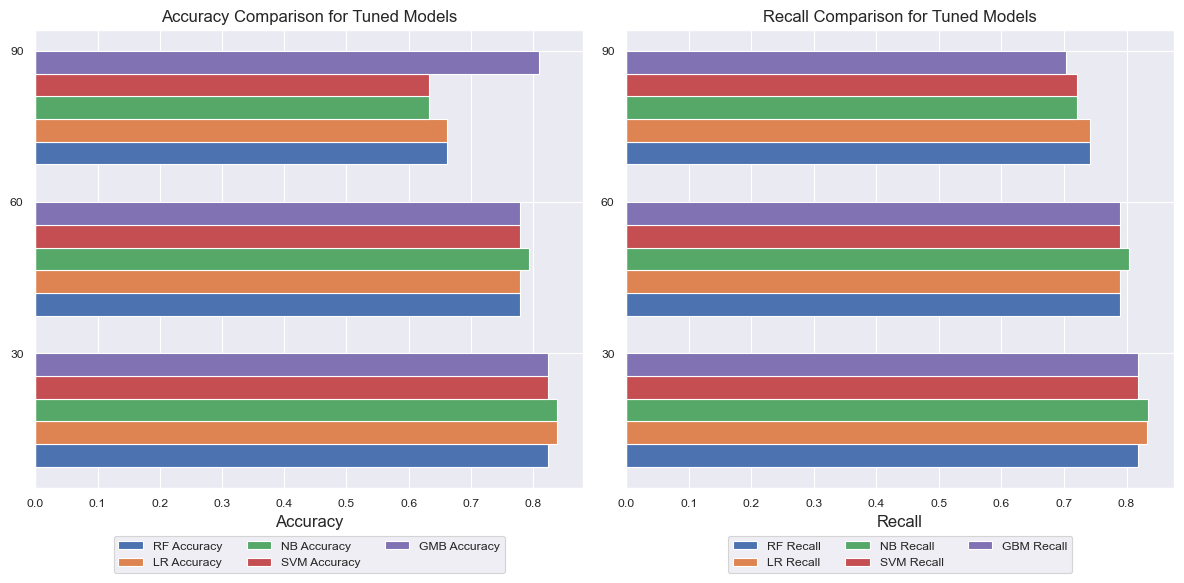

In [220]:
# Set the width of the bars
bar_width = 0.15

# Define the positions of the bars for GBM, SVM, RF, LR, and NB
bar_positions_rf = np.arange(len(targets))
bar_positions_lr = bar_positions_rf + bar_width
bar_positions_nb = bar_positions_lr + bar_width
bar_positions_svm = bar_positions_nb + bar_width
bar_positions_gbm = bar_positions_svm + bar_width

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the GBM accuracy and recall bars on subplot 1
ax1.barh(bar_positions_rf, rf_accuracy_values, height=bar_width, label='RF Accuracy')
ax1.barh(bar_positions_lr, lr_accuracy_values, height=bar_width, label='LR Accuracy')
ax1.barh(bar_positions_nb, nb_accuracy_values, height=bar_width, label='NB Accuracy')
ax1.barh(bar_positions_svm, svm_accuracy_values, height=bar_width, label='SVM Accuracy')
ax1.barh(bar_positions_gbm, gbm_accuracy_values, height=bar_width, label='GMB Accuracy')

ax1.set_xlabel('Accuracy')
ax1.set_yticks(bar_positions_gbm + bar_width / 2)
ax1.set_yticklabels(targets)
ax1.set_title('Accuracy Comparison for Tuned Models')
ax1.legend()

# Plot the recall bars on subplot 2

ax2.barh(bar_positions_rf, rf_recall_values, height=bar_width, label='RF Recall')
ax2.barh(bar_positions_lr, lr_recall_values, height=bar_width, label='LR Recall')
ax2.barh(bar_positions_nb, nb_recall_values, height=bar_width, label='NB Recall')
ax2.barh(bar_positions_svm, svm_recall_values, height=bar_width, label='SVM Recall')
ax2.barh(bar_positions_gbm, gbm_recall_values, height=bar_width, label='GBM Recall')

ax2.set_xlabel('Recall')
ax2.set_yticks(bar_positions_gbm + bar_width / 2)
ax2.set_yticklabels(targets)
ax2.set_title('Recall Comparison for Tuned Models')
ax2.legend()

# Move the legend to the bottom center
ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

plt.show()

## 